# 8-Slot Full Nerdle Solver Test
This is a much larger problem, so we don't optimize the initial guess and use instead the heuristic of having many different symbols. We stick to `9*8-7=65`which needs at most $X$ guesses and $X \pm X$ guesses.

In [1]:
%load_ext autoreload
%autoreload 2

import collections
import io
import itertools
import numpy as np
import matplotlib.pyplot as plt
import sys

import nerdle
import score as s
import generator
from nerdle import Hint, NerdleData

In [2]:
# Mini-Nerdle.
NUM_SLOTS = 8
SCORE_DB_FILE = "db/nerdle{}.db".format(NUM_SLOTS) 

%time solver_data = nerdle.create_solver_data(NUM_SLOTS, SCORE_DB_FILE)

CPU times: user 9.54 ms, sys: 1.64 s, total: 1.65 s
Wall time: 2.15 s


In [3]:
d = solver_data.score_db
d.shape

(17723, 17723)

## Example Usage

In [4]:
# score = nerdle.score_guess("10-43=66", "12+34=56")
# print(score, 
#       s.score_to_hint_string(score, NUM_SLOTS),
#       s.score_to_hints(score, NUM_SLOTS) == [Hint.CORRECT, Hint.ABSENT, Hint.ABSENT, Hint.PRESENT,
#                                Hint.PRESENT, Hint.CORRECT, Hint.ABSENT, Hint.CORRECT]
#      )

In [5]:
# A good initial guess significantly reduces the number of answers. In this case, from
# 206 to 10.
solver = nerdle.NerdleSolver(solver_data)
guess_history, hint_history, answer_size_history = solver.solve("5+6+6=17", initial_guess= "9*8-7=65", debug=True)

--> guess 9*8-7=65 guesses_left 5
score ----?+?? 42496
answers 71
--> guess 11+46=57 guesses_left 4
score ?-?-++?+ 25890
answers 2
--> guess 5+6+6=17 guesses_left 3
score ++++++++ 21845


In [6]:
# Nerdle of September 14, 2022.
# A good initial guess significantly reduces the number of answers. In this case, from 20177236 to 70.
solver = nerdle.NerdleSolver(solver_data)
#hint_generator = s.FileHintGenerator(sys.stdin)
hints = [
    "-----++?", 
    "+-+?-+--",
    "++++++++",
]
hint_generator = s.FileHintGenerator(io.StringIO("\n".join(hints)))
%time guess_history, hint_history, answer_size_history = solver.solve_adversary(hint_generator.__call__, initial_guess= "9*8-7=65", debug=True)

--> guess 9*8-7=65 guesses_left 5
score -----++? 37888
answers 70
--> guess 11+23=34 guesses_left 4
score +-+?-+-- 1169
answers 2
--> guess 10+52=62 guesses_left 3
score ++++++++ 21845
CPU times: user 554 ms, sys: 48.9 ms, total: 603 ms
Wall time: 607 ms


## Benchmark
This is a fast in-memory dict implementation.

In [7]:
# Nerdle of September 14, 2022.
solver = nerdle.NerdleSolver(solver_data)
%time guess_history, hint_history, answer_size_history = solver.solve("10+52=62", initial_guess="9*8-7=65")

CPU times: user 514 ms, sys: 1.49 ms, total: 515 ms
Wall time: 515 ms


## Optimal Initial Guess
After taking a look at https://github.com/starypatyk/nerdle-solver, I realized that there's no need to solve for all possible answers to get a good, if not optimal, initial guess. We just find the guess that minimizes the maximum answer bucket size, just like during the solution process.

In fact, once we know the initial guess, we could run it for all possible answers to evaluate its performance. (Can we calculate the distribution of #guesses in advance without doing that?) Note that we can memoize the solutions as we go (dynamic programming).

and build a lookup table of guesses vs. hints, and just use this static table; although recalculation takes just 0.5 seconds now, anyway, so there's no need to do that.

In [11]:
d = solver_data.score_db
%time v = np.array([max(collections.Counter(d[k]).values()) for k in range(d.shape[0])])
v_opt, k_opt = min((v[k], k) for k in range(d.shape[0]))
start = solver_data.answers[k_opt]
print("#answers in largest bucket {} start {}".format(v_opt, start))

IndexError: Replacement index 1 out of range for positional args tuple

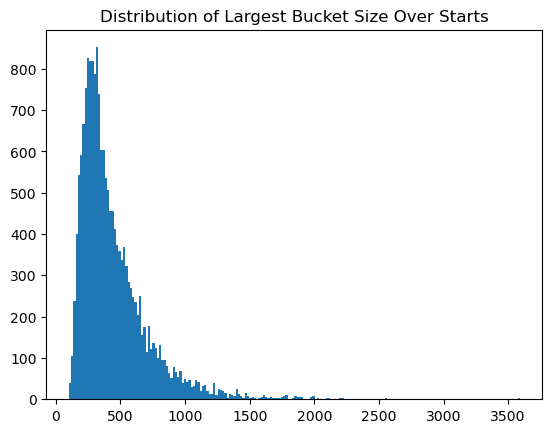

In [17]:
plt.hist(v, 200)
plt.title("Distribution of Largest Bucket Size Over Starts");

In [21]:
v.mean(), v.std(), np.median(v), v.min(), v.max()

(443.0653952491113, 270.4826103028963, 365.0, 101, 3590)

In [24]:
print("Best initial guess {}".format(solver_data.answers[v.argmin()]))
print("Worst initial guess {}".format(solver_data.answers[v.argmax()]))

Best initial guess 58-46=12
Worst initial guess 8*86=688


In [8]:
solutions = [nerdle.NerdleSolver(solver_data).solve(answer, initial_guess=start) 
             for answer in solver_data.answers]               
n = np.array([len(solution[0]) for solution in solutions])
num_answers = len(solver_data.answers)
compression_ratio = num_answers / np.array([solution[2][0] for solution in solutions])
print(np.mean(compression_ratio), np.std(compression_ratio))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.hist(n);
ax.set_title("#Guesses for start {}".format(start));

ax = axs[1]
ax.hist(compression_ratio);
ax.set_title("Compression Ratio Distribution, start {}".format(start));


KeyboardInterrupt

